# DataLoaderKGAT

In [76]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [77]:
import os
import sys
import random
from time import time

import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

from model.KGAT import KGAT
from parser.parser_kgat import *
from utils.log_helper import *
from utils.metrics import *
from utils.model_helper import *
# from data_loader.loader_kgat import DataLoaderKGAT

In [79]:
import os
import random
import collections

import torch
import numpy as np
import pandas as pd
import scipy.sparse as sp

from data_loader.loader_base import DataLoaderBase

class DataLoaderKGAT(DataLoaderBase):
    def __init__(self, args, logging):
        super().__init__(args, logging)
        '''
            DataLoaderBase.__init__()
            self.cf_train_data, self.train_user_dict = self.load_cf(self.train_file)
            self.cf_test_data, self.test_user_dict = self.load_cf(self.test_file)
        '''
        self.cf_batch_size = args.cf_batch_size
        self.kg_batch_size = args.kg_batch_size
        self.test_batch_size = args.test_batch_size

        self.kg_data = self.load_kg(self.kg_file)
        # debug : step by step
        # self.construct_data(kg_data)
        # self.print_info(logging)

        self.laplacian_type = args.laplacian_type
        # debug : step by step
        # self.create_adjacency_dict()
        # self.create_laplacian_dict()

## DataLoaderKGAT.__init__...

In [114]:
args = parse_kgat_args()

# Custom args for testing
args.use_pretrain = 0
args.data_name = ["last-fm", "yelp2018", "amazon-book"][2]

data = DataLoaderKGAT(args, logging)

In [115]:
display(data.cf_train_data)  # user, item (rating)
display((len(data.cf_train_data[0]), len(data.cf_train_data[1])))
display(f"user id range : {min(data.cf_train_data[0])}~{max(data.cf_train_data[0])}")
display(f"item id range : {min(data.cf_train_data[1])}~{max(data.cf_train_data[1])}")

(array([    0,     0,     0, ..., 70678, 70678, 70678], dtype=int32),
 array([    0,     1,     2, ...,  6576, 15701,  3614], dtype=int32))

(652514, 652514)

'user id range : 0~70678'

'item id range : 0~24914'

In [116]:
data.n_users, data.n_items, data.n_cf_train, data.n_cf_test, data.n_cf_train+data.n_cf_test
fullSize = data.n_users * data.n_items
validity = data.n_cf_train+data.n_cf_test
print(f"n_users : {data.n_users}, n_items: {data.n_items}, n_cf: {validity}")
print(f"Sparsity={(1.0 - validity / fullSize) * 100.0:.3f}%")

n_users : 70679, n_items: 24915, n_cf: 846434
Sparsity=99.952%


,h,r,t
0,24915,0,24916
1,24917,1,5117
2,24918,0,24917
3,24919,1,24920
4,24921,2,24922
...,...,...,...
2557741,55167,3,24942
2557742,24925,1,67332
2557743,41753,0,24942
2557744,24923,1,97956


,h,r,t
count,2557746.00,2557746.00,2557746.00
mean,45356.63,2.93,34726.32
std,30735.92,3.85,23555.93
min,0.00,0.00,0.00
25%,24917.00,0.00,24917.00
50%,29917.00,1.00,24925.00
75%,69850.00,3.00,28932.00
max,113486.00,38.00,113486.00


array([[<AxesSubplot:title={'center':'h'}>,
        <AxesSubplot:title={'center':'r'}>,
        <AxesSubplot:title={'center':'t'}>]], dtype=object)

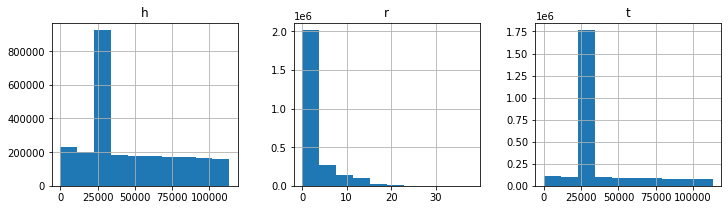

In [117]:
display(data.kg_data)
display(data.kg_data.describe().apply(lambda s: s.apply('{0:.2f}'.format)))
display(data.kg_data.hist(figsize=(12,3), layout=(1,3)))

## DataLoaderKGAT.construct_data

In [118]:
    kg_data = data.kg_data

    # add inverse kg data
    n_relations = max(kg_data['r']) + 1
    inverse_kg_data = kg_data.copy()
    inverse_kg_data = inverse_kg_data.rename({'h': 't', 't': 'h'}, axis='columns')
    inverse_kg_data['r'] += n_relations
    kg_data = pd.concat([kg_data, inverse_kg_data], axis=0, ignore_index=True, sort=False)

,h,r,t
0,24915,0,24916
1,24917,1,5117
2,24918,0,24917
3,24919,1,24920
4,24921,2,24922
...,...,...,...
5115487,24942,42,55167
5115488,67332,40,24925
5115489,24942,39,41753
5115490,97956,40,24923


,h,r,t
count,5115492.00,5115492.00,5115492.00
mean,40041.48,22.43,40041.48
std,27893.37,19.88,27893.37
min,0.00,0.00,0.00
25%,24917.00,1.00,24917.00
50%,24942.00,38.50,24942.00
75%,55227.00,40.00,55227.00
max,113486.00,77.00,113486.00


array([[<AxesSubplot:title={'center':'h'}>,
        <AxesSubplot:title={'center':'r'}>,
        <AxesSubplot:title={'center':'t'}>]], dtype=object)

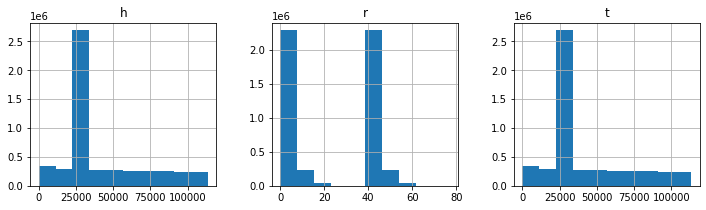

In [119]:
display(kg_data)
display(kg_data.describe().apply(lambda s: s.apply('{0:.2f}'.format)))
display(kg_data.hist(figsize=(12,3), layout=(1,3)))

In [120]:
    # re-map user id
    kg_data['r'] += 2
    data.n_relations = max(kg_data['r']) + 1
    data.n_entities = max(max(kg_data['h']), max(kg_data['t'])) + 1
    data.n_users_entities = data.n_users + data.n_entities

    data.cf_train_data = (np.array(list(map(lambda d: d + data.n_entities, data.cf_train_data[0]))).astype(np.int32), data.cf_train_data[1].astype(np.int32))
    data.cf_test_data = (np.array(list(map(lambda d: d + data.n_entities, data.cf_test_data[0]))).astype(np.int32), data.cf_test_data[1].astype(np.int32))

    data.train_user_dict = {k + data.n_entities: np.unique(v).astype(np.int32) for k, v in data.train_user_dict.items()}
    data.test_user_dict = {k + data.n_entities: np.unique(v).astype(np.int32) for k, v in data.test_user_dict.items()}

,h,r,t
0,24915,2,24916
1,24917,3,5117
2,24918,2,24917
3,24919,3,24920
4,24921,4,24922
...,...,...,...
5115487,24942,44,55167
5115488,67332,42,24925
5115489,24942,41,41753
5115490,97956,42,24923


,h,r,t
count,5115492.00,5115492.00,5115492.00
mean,40041.48,24.43,40041.48
std,27893.37,19.88,27893.37
min,0.00,2.00,0.00
25%,24917.00,3.00,24917.00
50%,24942.00,40.50,24942.00
75%,55227.00,42.00,55227.00
max,113486.00,79.00,113486.00


array([[<AxesSubplot:title={'center':'h'}>,
        <AxesSubplot:title={'center':'r'}>,
        <AxesSubplot:title={'center':'t'}>]], dtype=object)

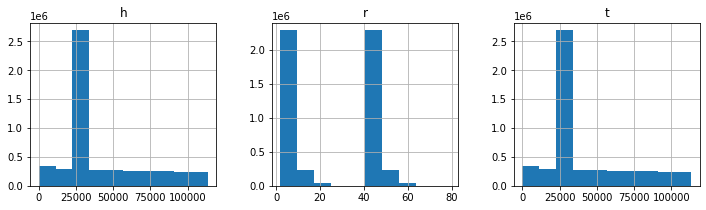

In [121]:
display(kg_data)
display(kg_data.describe().apply(lambda s: s.apply('{0:.2f}'.format)))
display(kg_data.hist(figsize=(12,3), layout=(1,3)))

In [122]:
display(data.cf_train_data)  # user, item (rating)
display((len(data.cf_train_data[0]), len(data.cf_train_data[1])))
display(f"user id range : {min(data.cf_train_data[0])}~{max(data.cf_train_data[0])}")
display(f"item id range : {min(data.cf_train_data[1])}~{max(data.cf_train_data[1])}")

(array([113487, 113487, 113487, ..., 184165, 184165, 184165], dtype=int32),
 array([    0,     1,     2, ...,  6576, 15701,  3614], dtype=int32))

(652514, 652514)

'user id range : 113487~184165'

'item id range : 0~24914'

In [123]:
    # add interactions to kg data
    cf2kg_train_data = pd.DataFrame(np.zeros((data.n_cf_train, 3), dtype=np.int32), columns=['h', 'r', 't'])
    cf2kg_train_data['h'] = data.cf_train_data[0]
    cf2kg_train_data['t'] = data.cf_train_data[1]

    inverse_cf2kg_train_data = pd.DataFrame(np.ones((data.n_cf_train, 3), dtype=np.int32), columns=['h', 'r', 't'])
    inverse_cf2kg_train_data['h'] = data.cf_train_data[1]
    inverse_cf2kg_train_data['t'] = data.cf_train_data[0]

    data.kg_train_data = pd.concat([kg_data, cf2kg_train_data, inverse_cf2kg_train_data], ignore_index=True)
    data.n_kg_train = len(data.kg_train_data)

,h,r,t
0,24915,2,24916
1,24917,3,5117
2,24918,2,24917
3,24919,3,24920
4,24921,4,24922
...,...,...,...
6420515,15786,1,184165
6420516,3631,1,184165
6420517,6576,1,184165
6420518,15701,1,184165


,h,r,t
count,6420520.00,6420520.00,6420520.00
mean,47358.62,19.57,47358.62
std,42037.48,20.19,42037.48
min,0.00,0.00,0.00
25%,24916.00,2.00,24916.00
50%,24942.00,5.00,24942.00
75%,69449.00,42.00,69449.00
max,184165.00,79.00,184165.00


array([[<AxesSubplot:title={'center':'h'}>,
        <AxesSubplot:title={'center':'r'}>,
        <AxesSubplot:title={'center':'t'}>]], dtype=object)

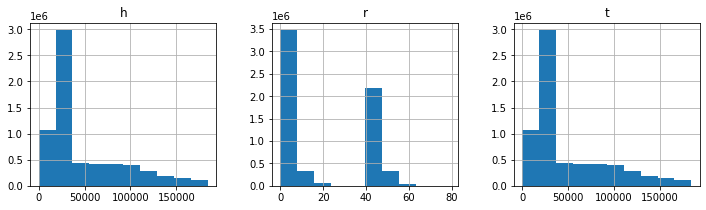

In [124]:
display(data.kg_train_data)
display(data.kg_train_data.describe().apply(lambda s: s.apply('{0:.2f}'.format)))
display(data.kg_train_data.hist(figsize=(12,3), layout=(1,3)))

In [125]:
    # construct kg dict
    h_list = []
    t_list = []
    r_list = []

    data.train_kg_dict = collections.defaultdict(list)
    data.train_relation_dict = collections.defaultdict(list)

    for row in data.kg_train_data.iterrows():
        h, r, t = row[1]
        h_list.append(h)
        t_list.append(t)
        r_list.append(r)

        data.train_kg_dict[h].append((t, r))
        data.train_relation_dict[r].append((h, t))

    data.h_list = torch.LongTensor(h_list)
    data.t_list = torch.LongTensor(t_list)
    data.r_list = torch.LongTensor(r_list)

In [126]:
len(h_list), len(t_list), len(r_list)

(6420520, 6420520, 6420520)

,h,r,t
92,25005,5,24916
64302,25005,2,24917
100025,25005,5,24923
212554,25005,7,27245
322110,25005,5,24942
774802,25005,5,24925
780176,25005,2,24925
1061590,25005,7,24979
1083297,25005,2,24923
1160405,25005,2,24942


,h,r,t
count,34.00,34.00,34.00
mean,25005.00,20.62,29919.94
std,0.00,20.28,14171.84
min,25005.00,2.00,24916.00
25%,25005.00,5.00,24920.00
50%,25005.00,7.00,24942.00
75%,25005.00,42.00,26935.00
max,25005.00,49.00,83546.00


array([[<AxesSubplot:title={'center':'h'}>,
        <AxesSubplot:title={'center':'r'}>,
        <AxesSubplot:title={'center':'t'}>]], dtype=object)

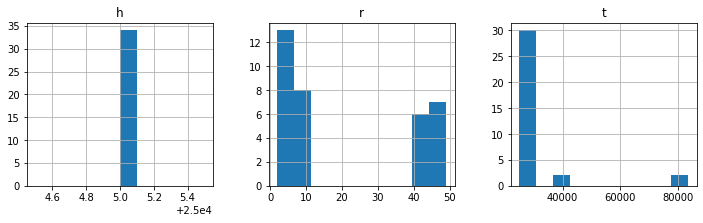

In [151]:
tmpPdf = data.kg_train_data[data.kg_train_data["r"]>=2.0]
tmpPdf = tmpPdf[tmpPdf["h"]==25005]
display(tmpPdf)
display(tmpPdf.describe().apply(lambda s: s.apply('{0:.2f}'.format)))
display(tmpPdf.hist(figsize=(12,3), layout=(1,3)))